In [2]:
# import libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [3]:
# %% Import csv, read data, rename column names
data35_25 = pd.read_csv("alldata[35.3, 25.1].csv")
data37_25 = pd.read_csv("alldata[37.4, 25.3].csv")
data39_26 = pd.read_csv("alldata[39.1, 26.5].csv")
data39_22 = pd.read_csv("alldata[39.3, 22.9].csv")
data39_19 = pd.read_csv("alldata[39.6, 19.9].csv")
data40_24 = pd.read_csv("alldata[40.9, 24.4].csv")

new_columns = {'Date':'Date',
             'Tmax (C)':'Tmax',
             'Precip. (mm/day)':'PR',
             'Wind Speed (m/s)':'WN',
             'Cloudiness':'CC',
             'RH min':'RHmin'}


In [4]:

#list all csv into an list 
#to make them more managable
all_data = [data35_25,
            data37_25,
            data39_26,
            data39_22,
            data39_19,
            data40_24]

#rename column names
for i, df in enumerate(all_data):
    df.rename(columns=new_columns,inplace=True)
    

all_data[0].head()
data35_25.name = "data35_25"
data37_25.name = "data37_25"
data39_26.name = "data39_26"
data39_22.name = "data39_22"
data39_19.name = "data39_19"
data40_24.name = "data40_24"

data40_24

,Date,Tmax,PR,WN,CC,RHmin
0,1950-01-01,7.627557,0.000000e+00,2.019546,0.000000,64.390739
1,1950-01-02,7.575067,0.000000e+00,1.751048,91.792473,65.637352
2,1950-01-03,6.155206,4.879511e-08,4.011030,0.000000,73.511040
3,1950-01-04,5.707513,4.675190e-08,1.511556,100.000000,71.646843
4,1950-01-05,6.469629,5.942295e-13,1.955055,0.000000,59.881748
...,...,...,...,...,...,...
20449,2005-12-27,9.198633,0.000000e+00,0.779395,39.829575,69.387703
20450,2005-12-28,11.005212,1.247123e-01,3.946664,100.000000,87.020348
20451,2005-12-29,11.242975,1.526466e+01,7.071550,100.000000,86.557060
20452,2005-12-30,9.456903,0.000000e+00,2.648607,0.000000,65.611755


Columns before cleanup: 20454
20454
20454
20454
20454
20454
20454


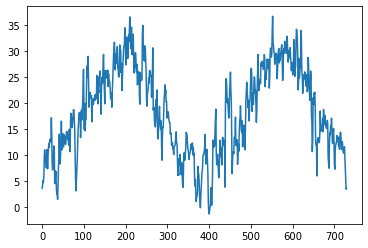

In [5]:
# Data cleaning
def cleanup(df):
    df = df.dropna()
    print(df.shape[0])
    return df
    
    

print('Columns before cleanup: %d'% all_data[0].shape[0])
add_data = [cleanup(df) for df in all_data]

# plot max temperature over the span of 2 years
plt.plot(all_data[3]['Tmax'][:730])

In [6]:
# define helper functions
def EtToRank(temp):
    temperature_ranges = {
        (39, float('inf')): 0,
        (37, 39): 2,
        (35, 37): 4,
        (33, 35): 5,
        (31, 33): 6,
        (29, 31): 7,
        (27, 29): 8,
        (26, 27): 9,
        (23, 26): 10,
        (20, 23): 9,
        (18, 20): 7,
        (15, 18): 6,
        (11, 15): 5,
        (7, 11): 4,
        (0, 7): 3,
        (-6, -0): 2,
        (-float('inf'), -6): 1
    }

    for (lower, upper), tsn in temperature_ranges.items():
        if lower < temp <= upper :
            return tsn

    return None  # Return a default value if no range is matched


def CCToRank(coverage):
    Cloud_coverage_ranges = {
        (10,20): 10,
        (1, 10): 9,
        (20, 30): 9,
        (30, 40): 8,
        (40, 50): 7,
        (50, 60): 6,
        (60, 70): 5,
        (70, 80): 4,
        (80, 90): 3,
        (90, 100): 2,
    }

    for (lower, upper), cc in Cloud_coverage_ranges.items():
        if coverage < 1:
            return 8
        elif coverage >= 100:
            return 1
        elif lower <= coverage < upper :
            return cc

    return None  # Return a default value if no range is matched


def PRToRank(pr):
    Pr_coverage_ranges = {
        (0,3): 9,
        (3,6): 8,
        (6,9): 5,
        (9,12): 2,
        (12,25): 0,
        (25,float('inf')): -1
    }

    for (lower, upper), item in Pr_coverage_ranges.items():
        if pr == 0:
            return 10
        elif lower <= pr < upper:
            return item

    return None  # Return a default value if no range is matched



def WNToRank(windSpeed):
    Wn_coverage_ranges = {
        (0.277777778,2.5): 10,
        (2.5,5.27777778): 9,
        (5.27777778,8.05555556): 8,
        (8.05555556,10.8333333): 6,
        (10.8333333,13.6111111): 3,
        (13.6111111,19.4444445): 0,
        (19.4444445,float('inf')): -10
    }

    for (lower, upper), item in Wn_coverage_ranges.items():
        if windSpeed == 0:
            return 8
        elif lower <= windSpeed < upper:
            return item

    return None  # Return a default value if no range is matched

def TsToRank(ts):
    Ts_coverage_ranges = {
        (-float('inf'),21): -4,
        (21,26): -3,
        (26,29): -2,
        (29,31): -1,
        (31,32.5): 0,
        (32.5,33.5): 1,
        (33.5,34.5): 2,
        (34.5,35.5): 3,
        (35.5,float('inf')): 4
    
    }

    for (lower, upper), item in Ts_coverage_ranges.items():
        if ts == 0:
            return 8
        elif lower <= ts < upper:
            return item

    return None  # Return a default value if no range is matched




In [7]:
#to verify conversions
temperature = 2.01954555511474
tsn = WNToRank(temperature)
print(f"The TSN value for temperature {temperature} is {tsn}")

The TSN value for temperature 2.01954555511474 is 10


In [8]:
def Calculate_Cit(row):
    s = (100.0-row['CC'])/100
    
    Ts = row['Tmax']+ 1/7*h*M + ((M-15) + 120*s*(1-A) / 2+9*math.sqrt(0.1+row['WN']))
    Ts_ranking = TsToRank(Ts)
    result = (6.4 + (0.4*Ts_ranking) - (0.281*Ts_ranking**2))
    
    return result

def Calculate_Hci(row):
    Et = (row['Tmax']-(0.4*(row['Tmax']-10))) * (1-row['RHmin']/100)
    Et_ranking = EtToRank(Et)
    CC_ranking = CCToRank(row['CC'])
    PR_ranking = PRToRank(row['PR'])
    WN_ranking = WNToRank(row['WN'])
    
    result = (4*Et_ranking + 2*CC_ranking + 3*PR_ranking + WN_ranking)
    return result
   


In [9]:
for i,df in enumerate(all_data):
    #calculate CIT metric
    h = 0.008
    M = 25
    A = 0.45

    df['Cit'] = df.apply(Calculate_Cit, axis=1)
    
    #calculate HCI metric
    df['Hci'] = df.apply(Calculate_Hci, axis=1)
    
    

In [10]:
monthly_yearly_avg = {}
for i,df in enumerate(all_data):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract year and month as separate columns
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    
    # Group by year and month and calculate the mean
    monthly_yearly_avg[df.name] = df.groupby(['Year', 'Month'])['Hci'].mean().reset_index()
    monthly_yearly_avg[df.name]['Cit'] = df.groupby(['Year', 'Month'])['Cit'].mean().reset_index().drop(columns=['Year', 'Month'])
    #df = df.drop(columns=['Year', 'Month'],inplace = True)

In [11]:
monthly_avg = {}
for i,df in enumerate(all_data):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract year and month as separate columns
    df['Month'] = df['Date'].dt.month
    
    # Group by  month and calculate the mean
    monthly_avg[df.name] = df.groupby(['Month'])['Hci'].mean().reset_index()
    monthly_avg[df.name]['Cit'] = df.groupby(['Month'])['Cit'].mean().reset_index().drop(columns=['Month'])
    df = df.drop(columns=['Year', 'Month'],inplace = True)


In [12]:
#Save all results as excel file
#for i,df in enumerate(all_data):
for i,df in enumerate(all_data):
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df.to_excel("results/"+df.name+".xlsx")
    monthly_yearly_avg[df.name].to_excel("results/monthly_yearly_avg_"+df.name+".xlsx")
    monthly_avg[df.name].to_excel("results/monthly_avg_"+df.name+".xlsx")
    
    